In [1]:
import ROOT
from ROOT import TMVA
import uproot
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

plt.rc('axes', **{'grid':False, 'titlesize':'large', 'labelsize':'large'})
plt.rc('xtick', labelsize = 16)
plt.rc('ytick', labelsize = 16)

import seaborn as sns

sns.set(rc={'axes.axisbelow': False,'axes.edgecolor': 'grey','axes.facecolor': 'None','axes.grid': False,
            'grid.color': 'gainsboro','axes.labelcolor': 'dimgrey','axes.spines.right': False,'axes.spines.top': False,
            'figure.facecolor': 'white','lines.solid_capstyle': 'round','text.color': 'dimgrey','xtick.bottom': False,
            'xtick.color': 'dimgrey','xtick.direction': 'out','xtick.top': False,'ytick.color': 'dimgrey',
            'ytick.direction': 'out','ytick.left': False,'ytick.right': False})

sns.set_context("notebook", rc={"font.size":12, "axes.titlesize":16, "axes.labelsize":14})

Welcome to JupyROOT 6.24/00


In [2]:
dirOutPath = '/data/Skim/'

listDir = os.listdir(dirOutPath)

In [3]:
SignalFlat = [0]*4
MCFlat = [0]*4

for i in range(1,5):
    SignalFlat[i-1] = uproot.open(dirOutPath + 'SignalFlat{}.root:Events'.format(i)).arrays(library='pd')
    MCFlat[i-1] = uproot.concatenate(dirOutPath + 'MC*{}.root:Events'.format(i), allow_missing=True, library='pd')
    
    SignalFlat[i-1]['label'] = 'signal'
    MCFlat[i-1]['label'] = 'bkg'
    
diLepton = pd.concat((SignalFlat[0], SignalFlat[1]))
triLepton = pd.concat((SignalFlat[2], SignalFlat[3]))

diLepton = pd.concat((diLepton, MCFlat[0], MCFlat[1]))
triLepton = pd.concat((triLepton, MCFlat[2], MCFlat[3]))

In [6]:
# drop weights
diLepton = diLepton.drop(columns=['eventWeightLumi'])
triLepton = triLepton.drop(columns=['eventWeightLumi'])

<ipython-input-13-149c20aad5fb>:4: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("vlag").copy()
  color.set_bad('lightblue')


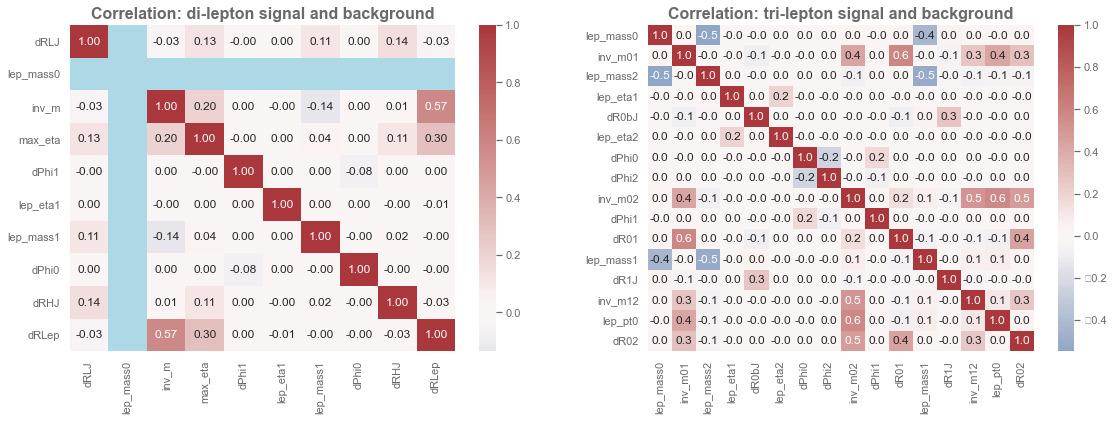

In [13]:
di_corr = diLepton.corr()
tri_corr = triLepton.corr()
color = plt.get_cmap('vlag')
color.set_bad('lightblue')
f_corr, (ax_di_corr, ax_tri_corr) = plt.subplots(nrows=1, ncols=2, figsize=(19,6))
ax_di_corr.set_title('Correlation: di-lepton signal and background', fontweight="bold")
tabc_sgn = sns.heatmap(di_corr, center=0, cmap='vlag', annot=True, fmt='.2f', linewidths=0,
            xticklabels=di_corr.columns.values, yticklabels=di_corr.columns.values, ax=ax_di_corr)

ax_tri_corr.set_title('Correlation: tri-lepton signal and background', fontweight="bold")
tabc_corr = sns.heatmap(tri_corr, center=0, cmap='vlag', annot=True, fmt='.1f', linewidths=0,
            xticklabels=tri_corr.columns.values, yticklabels=tri_corr.columns.values, ax=ax_tri_corr)

## Instantiate factory

In [14]:
ROOT.TMVA.Tools.Instance()
## For PYMVA methods
TMVA.PyMethodBase.PyInitialize();


outputFile = ROOT.TFile.Open("Classification.root", "RECREATE")

factory = ROOT.TMVA.Factory("TMVA_Classification", outputFile,
                      "!V:ROC:!Silent:Color:!DrawProgressBar:AnalysisType=Classification" )

## Load data

In [15]:
def loadData(chain, pathDirs, info=False):
    # Set up multi-threading capability of ROOT
    ROOT.ROOT.EnableImplicitMT()
    
    for file in pathDirs:
        if info: print('>>> Process directory ', Dir)
        tmp = ROOT.TFile.Open(dirOutPath + file)
        try:
            tmp.Get("Events").GetEntries()
            chain.Add(dirOutPath + file)
        except:
            continue
            
    return chain

def returnFiles(string, nSkim):
    return [filename for filename in listDir if (filename.startswith(string) and filename.endswith(str(nSkim)+'.root'))]

In [16]:
bkg_files2 = returnFiles('MC',1) + returnFiles('MC',2)
bkg_files3 = returnFiles('MC',3) + returnFiles('MC',4)
sig_files2 = returnFiles('Sig',1) + returnFiles('Sig',2)
sig_files3 = returnFiles('Sig',3) + returnFiles('Sig',4)
dat_files2 = returnFiles('Dat',1) + returnFiles('Dat',2)
dat_files3 = returnFiles('Dat',3) + returnFiles('Dat',4)

### BKG ###
chain_bkg2 = ROOT.TChain('Events')
chain_bkg2 = loadData(chain_bkg2, bkg_files2)

chain_bkg3 = ROOT.TChain('Events')
chain_bkg3 = loadData(chain_bkg3, bkg_files3)

### SIGNAL ###
chain_sig2 = ROOT.TChain('Events')
chain_sig2 = loadData(chain_sig2, sig_files2)

chain_sig3 = ROOT.TChain('Events')
chain_sig3 = loadData(chain_sig3, sig_files3)

### DATA ###
chain_dat2 = ROOT.TChain('Events')
chain_dat2 = loadData(chain_dat2, dat_files2)

chain_dat3 = ROOT.TChain('Events')
chain_dat3 = loadData(chain_dat3, dat_files3)

## Add variables

In [18]:
signalWeight     = 1.0
backgroundWeight = 1.0


### LOADER 2 ###
loader2 = ROOT.TMVA.DataLoader("dataset")

loader2.AddSignalTree(chain_sig2, signalWeight)
loader2.AddBackgroundTree(chain_bkg2, backgroundWeight)

var2 = ['lep_mass0','lep_mass1','max_eta','lep_eta1','inv_m','dRHJ','dRLJ','dPhi0','dPhi1']
for var in var2:
    loader2.AddVariable(var)


### LOADER 3 ###
loader3 = ROOT.TMVA.DataLoader("dataset")

loader3.AddSignalTree(chain_sig3, signalWeight)
loader3.AddBackgroundTree(chain_bkg3, backgroundWeight)

var3 = ['lep_pt0','inv_m01','lep_eta1','lep_eta2','inv_m12','dR1J','dR0bJ','dR01','dPhi0','dPhi1','dPhi2']

for var in var3:
    loader3.AddVariable(var)


DataSetInfo              : [dataset] : Added class "Signal"
                         : Add Tree Events of type Signal with 8323 events
DataSetInfo              : [dataset] : Added class "Background"
                         : Add Tree Events of type Background with 121758 events
DataSetInfo              : [dataset] : Added class "Signal"
                         : Add Tree Events of type Signal with 5107 events
DataSetInfo              : [dataset] : Added class "Background"
                         : Add Tree Events of type Background with 161067 events


## Train & test

In [19]:
void_cut = ROOT.TCut('')

loader2.PrepareTrainingAndTestTree(void_cut, void_cut,
                                  "nTrain_Signal=6659:nTrain_Background=97407:SplitMode=Random:"
                                   "NormMode=NumEvents:!V" )
loader3.PrepareTrainingAndTestTree(void_cut, void_cut,
                                  "nTrain_Signal=4086:nTrain_Background=128854:SplitMode=Random:"
                                   "NormMode=NumEvents:!V" )

In [20]:
factory.BookMethod(loader2,ROOT.TMVA.Types.kBDT, "BDT2",
                   "!V:NTrees=200:MinNodeSize=2.5%:MaxDepth=2:BoostType=AdaBoost:AdaBoostBeta=0.5:UseBaggedBoost:"
                   "BaggedSampleFraction=0.5:SeparationType=SDivSqrtSPlusB:nCuts=20" )

factory.BookMethod(loader3,ROOT.TMVA.Types.kBDT, "BDT3",
                   "!V:NTrees=200:MinNodeSize=2.5%:MaxDepth=2:BoostType=AdaBoost:AdaBoostBeta=0.5:UseBaggedBoost:"
                   "BaggedSampleFraction=0.5:SeparationType=SDivSqrtSPlusB:nCuts=20" )

Factory                  : Booking method: BDT2
                         : 
                         : Building event vectors for type 2 Signal
                         : Dataset[dataset] :  create input formulas for tree Events
                         : Dataset[dataset] :  create input formulas for tree Events
                         : Dataset[dataset] :  create input formulas for tree Events
                         : Building event vectors for type 2 Background
                         : Dataset[dataset] :  create input formulas for tree Events
                         : Dataset[dataset] :  create input formulas for tree Events
                         : Dataset[dataset] :  create input formulas for tree Events
                         : Dataset[dataset] :  create input formulas for tree Events
                         : Dataset[dataset] :  create input formulas for tree Events
                         : Dataset[dataset] :  create input formulas for tree Events
                   

In [21]:
factory.TrainAllMethods()

Factory                  : Train all methods
Factory                  : [dataset] : Create Transformation "I" with events from all classes.
                         : 
                         : Transformation, Variable selection : 
                         : Input : variable 'lep_mass0' <---> Output : variable 'lep_mass0'
                         : Input : variable 'lep_mass1' <---> Output : variable 'lep_mass1'
                         : Input : variable 'max_eta' <---> Output : variable 'max_eta'
                         : Input : variable 'lep_eta1' <---> Output : variable 'lep_eta1'
                         : Input : variable 'inv_m' <---> Output : variable 'inv_m'
                         : Input : variable 'dRHJ' <---> Output : variable 'dRHJ'
                         : Input : variable 'dRLJ' <---> Output : variable 'dRLJ'
                         : Input : variable 'dPhi0' <---> Output : variable 'dPhi0'
                         : Input : variable 'dPhi1' <---> Output : variab

In [22]:
factory.TestAllMethods()

Factory                  : Test all methods
Factory                  : Test method: BDT2 for Classification performance
                         : 
BDT2                     : [dataset] : Evaluation of BDT2 on testing sample (26015 events)
                         : Elapsed time for evaluation of 26015 events: 0.136 sec       
Factory                  : Test method: BDT3 for Classification performance
                         : 
BDT3                     : [dataset] : Evaluation of BDT3 on testing sample (33234 events)
                         : Elapsed time for evaluation of 33234 events: 0.178 sec       


In [23]:
factory.EvaluateAllMethods()

Factory                  : Evaluate all methods
Factory                  : Evaluate classifier: BDT2
                         : 
BDT2                     : [dataset] : Loop over test events and fill histograms with classifier response...
                         : 
<WARNING>                : Variable "lep_mass0" has zero, negative, or NaN RMS^2: -nan ==> set to zero. Please check the variable content
TFHandler_BDT2           :  Variable         Mean         RMS   [        Min         Max ]
                         : ----------------------------------------------------------------
                         : lep_mass0:    0.10570 8.7930e-08   [    0.10570    0.10570 ]
                         : lep_mass1:   0.058505   0.052317   [ 0.00051100    0.10570 ]
                         :   max_eta:     1.3509    0.58068   [   0.011782     2.4556 ]
                         :  lep_eta1: -0.0078649     1.2106   [    -2.4556     2.4521 ]
                         :     inv_m:     146.44     114.62  

In [24]:
outputFile.Close()

## Evaluation

In [25]:
read = ROOT.TFile.Open('Classification.root')

In [26]:
from array import array
lep_mass0 = array('f',[0])
lep_mass1 = array('f',[0])
max_eta = array('f',[0])
lep_eta1 = array('f',[0])
inv_m = array('f',[0])
dRHJ = array('f',[0])
dRLJ = array('f',[0])
dPhi0 = array('f',[0])
dPhi1 = array('f',[0])

sig_hist = read.Get('dataset/Method_BDT/BDT2/MVA_BDT2_S')
bkg_hist = read.Get('dataset/Method_BDT/BDT2/MVA_BDT2_B')

nbins = sig_hist.GetXaxis().GetNbins()
xmin = sig_hist.GetXaxis().GetXmin()
xmax = sig_hist.GetXaxis().GetXmax()

reader = TMVA.Reader("evaluation")

reader.AddVariable("lep_mass0", lep_mass0)
reader.AddVariable("lep_mass1", lep_mass1)
reader.AddVariable("max_eta", max_eta)
reader.AddVariable("lep_eta1", lep_eta1)
reader.AddVariable("inv_m", inv_m)
reader.AddVariable("dRHJ", dRHJ)
reader.AddVariable("dRLJ", dRLJ)
reader.AddVariable("dPhi0", dPhi0)
reader.AddVariable("dPhi1", dPhi1)

weightfile = "dataset/weights/TMVA_Classification_BDT2.weights.xml"

reader.BookMVA('BDT2', weightfile)

d2 = ROOT.TH1D("d2","Classifier Output on Data Events",30,-1,1)
s2 = ROOT.TH1D("s2","Classifier Output on Signal Events",30,-1,1)
b2 = ROOT.TH1D('b2',"Classifier Output on Background Events",30,-1,1)

for entry in chain_dat2:
    
    lep_mass0[0] = entry.lep_mass0
    lep_mass1[0] = entry.lep_mass1
    max_eta[0] = entry.max_eta
    lep_eta1[0] = entry.lep_eta1
    inv_m[0] = entry.inv_m
    dRHJ[0] = entry.dRHJ
    dRLJ[0] = entry.dRLJ
    dPhi0[0] = entry.dPhi0
    dPhi1[0] = entry.dPhi1
    
    output = reader.EvaluateMVA('BDT2')
  
    d2.Fill(output)
    
for entry in chain_sig2:
    
    lep_mass0[0] = entry.lep_mass0
    lep_mass1[0] = entry.lep_mass1
    max_eta[0] = entry.max_eta
    lep_eta1[0] = entry.lep_eta1
    inv_m[0] = entry.inv_m
    dRHJ[0] = entry.dRHJ
    dRLJ[0] = entry.dRLJ
    dPhi0[0] = entry.dPhi0
    dPhi1[0] = entry.dPhi1
    
    output = reader.EvaluateMVA('BDT2')
  
    s2.Fill(output)
    
for entry in chain_bkg2:
    
    lep_mass0[0] = entry.lep_mass0
    lep_mass1[0] = entry.lep_mass1
    max_eta[0] = entry.max_eta
    lep_eta1[0] = entry.lep_eta1
    inv_m[0] = entry.inv_m
    dRHJ[0] = entry.dRHJ
    dRLJ[0] = entry.dRLJ
    dPhi0[0] = entry.dPhi0
    dPhi1[0] = entry.dPhi1
    
    output = reader.EvaluateMVA('BDT2')
  
    b2.Fill(output, entry.eventWeightLumi)

                         : Booking "BDT2" of type "BDT" from dataset/weights/TMVA_Classification_BDT2.weights.xml.
                         : Reading weight file: dataset/weights/TMVA_Classification_BDT2.weights.xml
<HEADER> DataSetInfo              : [Default] : Added class "Signal"
<HEADER> DataSetInfo              : [Default] : Added class "Background"
                         : Booked classifier "BDT2" of type: "BDT"


In [27]:
from array import array
lep_pt0 = array('f',[0])
inv_m01 = array('f',[0])
lep_eta1 = array('f',[0])
lep_eta2 = array('f',[0])
inv_m12 = array('f',[0])
dR1J = array('f',[0])
dR0bJ = array('f',[0])
dR01 = array('f',[0])
dPhi0 = array('f',[0])
dPhi1 = array('f',[0])
dPhi2 = array('f',[0])

sig_hist = read.Get('dataset/Method_BDT/BDT3/MVA_BDT3_S')
bkg_hist = read.Get('dataset/Method_BDT/BDT3/MVA_BDT3_B')

nbins = sig_hist.GetXaxis().GetNbins()
xmin = sig_hist.GetXaxis().GetXmin()
xmax = sig_hist.GetXaxis().GetXmax()

reader = TMVA.Reader("evaluation")

reader.AddVariable("lep_pt0", lep_pt0)
reader.AddVariable("inv_m01", inv_m01)
reader.AddVariable("lep_eta1", lep_eta1)
reader.AddVariable("lep_eta2", lep_eta2)
reader.AddVariable("inv_m12", inv_m12)
reader.AddVariable("dR1J", dR1J)
reader.AddVariable("dR0bJ", dR0bJ)
reader.AddVariable("dR01", dR01)
reader.AddVariable("dPhi0", dPhi0)
reader.AddVariable("dPhi1", dPhi1)
reader.AddVariable("dPhi2", dPhi2)

weightfile = "dataset/weights/TMVA_Classification_BDT3.weights.xml"

reader.BookMVA('BDT3', weightfile)

d3 = ROOT.TH1D("d3","Classifier Output on Data Events",30,-1,1)
s3 = ROOT.TH1D("s3","Classifier Output on Signal Events",30,-1,1)
b3 = ROOT.TH1D("b3","Classifier Output on Background Events",30,-1,1)

for entry in chain_dat3:
    
    lep_pt0[0] = entry.lep_pt0
    inv_m01[0] = entry.inv_m01
    lep_eta1[0] = entry.lep_eta1
    lep_eta2[0] = entry.lep_eta2
    inv_m12[0] = entry.inv_m12
    dR1J[0] = entry.dR1J
    dR0bJ[0] = entry.dR0bJ
    dR01[0] = entry.dR01
    dPhi0[0] = entry.dPhi0
    dPhi1[0] = entry.dPhi1
    dPhi2[0] = entry.dPhi2
    
    output = reader.EvaluateMVA('BDT3')
  
    d3.Fill(output)
    
for entry in chain_sig3:
    
    lep_pt0[0] = entry.lep_pt0
    inv_m01[0] = entry.inv_m01
    lep_eta1[0] = entry.lep_eta1
    lep_eta2[0] = entry.lep_eta2
    inv_m12[0] = entry.inv_m12
    dR1J[0] = entry.dR1J
    dR0bJ[0] = entry.dR0bJ
    dR01[0] = entry.dR01
    dPhi0[0] = entry.dPhi0
    dPhi1[0] = entry.dPhi1
    dPhi2[0] = entry.dPhi2
    
    output = reader.EvaluateMVA('BDT3')
  
    s3.Fill(output)
    
for entry in chain_bkg3:
    
    lep_pt0[0] = entry.lep_pt0
    inv_m01[0] = entry.inv_m01
    lep_eta1[0] = entry.lep_eta1
    lep_eta2[0] = entry.lep_eta2
    inv_m12[0] = entry.inv_m12
    dR1J[0] = entry.dR1J
    dR0bJ[0] = entry.dR0bJ
    dR01[0] = entry.dR01
    dPhi0[0] = entry.dPhi0
    dPhi1[0] = entry.dPhi1
    dPhi2[0] = entry.dPhi2
    
    output = reader.EvaluateMVA('BDT3')
  
    b3.Fill(output, entry.eventWeightLumi)

                         : Booking "BDT3" of type "BDT" from dataset/weights/TMVA_Classification_BDT3.weights.xml.
                         : Reading weight file: dataset/weights/TMVA_Classification_BDT3.weights.xml
<HEADER> DataSetInfo              : [Default] : Added class "Signal"
<HEADER> DataSetInfo              : [Default] : Added class "Background"
                         : Booked classifier "BDT3" of type: "BDT"


In [28]:
def plot_bdt(data, sig, bkg):    
    # Styles
    ROOT.gStyle.SetOptStat(0)
    ROOT.gStyle.SetCanvasBorderMode(0)
    ROOT.gStyle.SetCanvasColor(ROOT.kWhite)
    ROOT.gStyle.SetCanvasDefH(600)
    ROOT.gStyle.SetCanvasDefW(600)
    ROOT.gStyle.SetCanvasDefX(0)
    ROOT.gStyle.SetCanvasDefY(0)
    ROOT.gStyle.SetPadTopMargin(0.08)
    ROOT.gStyle.SetPadBottomMargin(0.13)
    ROOT.gStyle.SetPadLeftMargin(0.16)
    ROOT.gStyle.SetPadRightMargin(0.05)
    ROOT.gStyle.SetHistLineColor(1)
    ROOT.gStyle.SetHistLineStyle(0)
    ROOT.gStyle.SetHistLineWidth(1)
    ROOT.gStyle.SetEndErrorSize(2)
    ROOT.gStyle.SetMarkerStyle(20)
    ROOT.gStyle.SetOptTitle(0)
    ROOT.gStyle.SetTitleFont(42)
    ROOT.gStyle.SetTitleColor(1)
    ROOT.gStyle.SetTitleTextColor(1)
    ROOT.gStyle.SetTitleFillColor(10)
    ROOT.gStyle.SetTitleFontSize(0.05)
    ROOT.gStyle.SetTitleColor(1, 'XYZ')
    ROOT.gStyle.SetTitleFont(42, 'XYZ')
    ROOT.gStyle.SetTitleSize(0.05, 'XYZ')
    ROOT.gStyle.SetTitleXOffset(1.00)
    ROOT.gStyle.SetTitleYOffset(1.60)
    ROOT.gStyle.SetLabelColor(1, 'XYZ')
    ROOT.gStyle.SetLabelFont(42, 'XYZ')
    ROOT.gStyle.SetLabelOffset(0.007, 'XYZ')
    ROOT.gStyle.SetLabelSize(0.04, 'XYZ')
    ROOT.gStyle.SetAxisColor(1, 'XYZ')
    ROOT.gStyle.SetStripDecimals(True)
    ROOT.gStyle.SetTickLength(0.03, 'XYZ')
    ROOT.gStyle.SetNdivisions(510, 'XYZ')
    ROOT.gStyle.SetPadTickX(1)
    ROOT.gStyle.SetPadTickY(1)
    ROOT.gStyle.SetPaperSize(20., 20.)
    ROOT.gStyle.SetHatchesLineWidth(5)
    ROOT.gStyle.SetHatchesSpacing(0.05)
    ROOT.TGaxis.SetExponentOffset(-0.08, 0.01, 'Y')
    
    
    legend = ROOT.TLegend(0.6, 0.6, 0.9, 0.8)
    legend.SetNColumns(2)
    
    c = ROOT.TCanvas('', '', 600, 600)
    c.cd()
    
    sig.SetLineColor(ROOT.TColor.GetColor('#00A88F'))
    sig.SetLineWidth(3)
    sig.Draw('HIST')
    
    bkg.SetLineColor(2)
    bkg.SetLineColor(ROOT.TColor.GetColor(248, 206, 104))
    bkg.SetLineWidth(3)
    bkg.Draw('E2 hist same')
    
    
    data.SetMarkerStyle(20)
    data.SetLineColor(ROOT.kBlack)
    data.SetLineWidth(3)
    data.Draw('E1P SAME')
    
    sig.GetXaxis().SetTitle("BDT discriminant")
    sig.GetYaxis().SetTitle('N_{Events}')
    
     # Add legend
    legend.AddEntry(sig, 'Signal', 'f')
    legend.AddEntry(bkg, 'Background', 'f')
    legend.AddEntry(data, 'Data', 'lep')
    legend.SetBorderSize(0)
    legend.Draw('same')
    
    # Add title
    latex = ROOT.TLatex()
    latex.SetNDC()
    latex.SetTextSize(0.04)
    latex.SetTextFont(42)
    latex.DrawLatex(0.16, 0.935, '#bf{Boosted Decison Tree}')
    
    c.Draw()

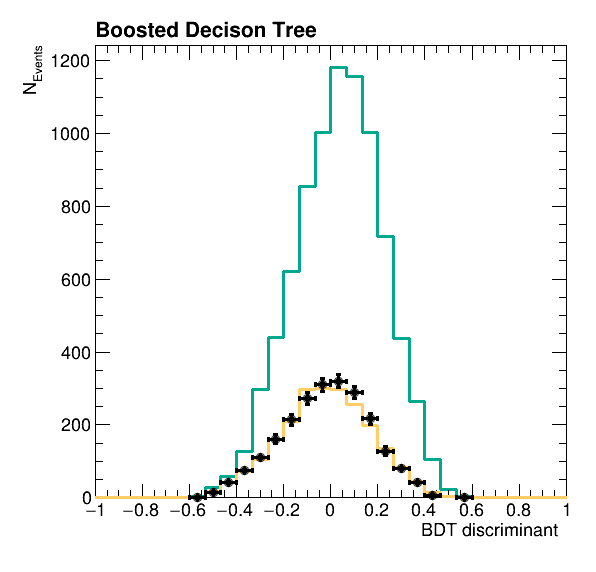

In [29]:
plot_bdt(d2, s2, b2)

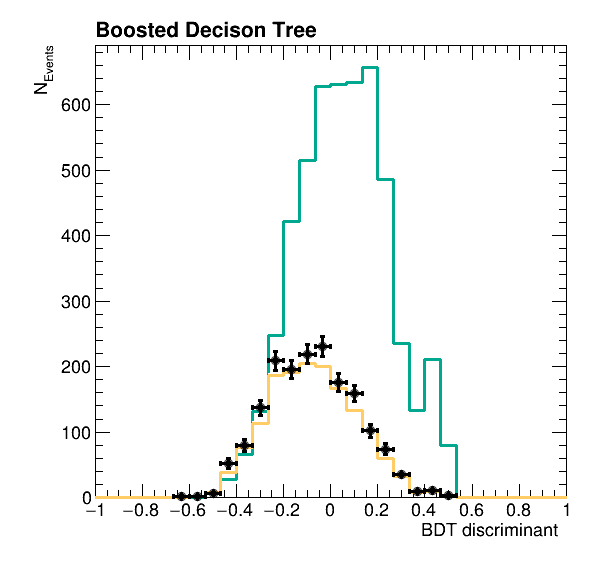

In [30]:
plot_bdt(d3, s3, b3)

## Statistics

In [97]:
import scipy as sp
from scipy.stats import poisson as ps

def stat(data_hist, sig_hist, bkg_hist):
    
    np.random.seed(12345)
    
    nbins, data, sig, bkg = 0, [], [], []
    
    for d,s,b in zip(data_hist,sig_hist,bkg_hist):

        tmp_bins = d.GetXaxis().GetNbins()
        data += [d.GetBinContent(i) for i in range(1, tmp_bins+1)]
        sig += [s.GetBinContent(i) for i in range(1, tmp_bins+1)]
        bkg += [b.GetBinContent(i) for i in range(1, tmp_bins+1)]
        nbins += tmp_bins
            
    data = np.array(data)
    sig = np.array(sig)
    bkg = np.array(bkg)
    data[data<0] = 0
    sig[sig<0] = 0
    bkg[bkg<0] = 0
        
    mu_grid = np.arange(0, 0.1, 1e-6)
    
    b_plus_sig = np.outer(sig, mu_grid) + np.tile(bkg,(len(mu_grid),1)).T
    
    like_grid = np.prod(ps.pmf(np.tile(data,(len(mu_grid),1)).T, b_plus_sig), axis=0)
    mu_best = mu_grid[np.argmax(like_grid)]
    b_plus_sig_best = bkg + sig*mu_best
      
    ntoys = int(1e5)
    bin_toys = 1000
    
    mu_min = 0.015
    mu_max = 0.02

    for i in range(30):
        mu = (mu_min+mu_max)/2
        #mu = 0.015
        
        b_plus_sig_mu = bkg + sig*mu
        toys = ps.rvs(np.tile(b_plus_sig_mu,(ntoys,1)).T, size=(nbins,ntoys))
        
        like_num0 = np.prod(ps.pmf(toys, np.tile(bkg,(ntoys,1)).T), axis=0)
        like_num1 = np.prod(ps.pmf(toys, np.tile(b_plus_sig_mu,(ntoys,1)).T), axis=0)
        like_den = np.prod(ps.pmf(toys, np.tile(b_plus_sig_best,(ntoys,1)).T), axis=0)
    
        q_mu0 = -2 * np.log(like_num0/like_den)
        q_mu1 = -2 * np.log(like_num1/like_den)
        
        like_num_obs = np.prod(ps.pmf(data, b_plus_sig_mu))
        like_den_obs = np.prod(ps.pmf(data, b_plus_sig_best))
        q_mu_obs = -2 * np.log(like_num_obs/like_den_obs)
        
        ### H0 ###
        values_0, bins_0, _ = plt.hist(q_mu0, bins=bin_toys, density=True)
        plt.close()
        mask = (bins_0 > q_mu_obs)
        p_b = sum(np.diff(bins_0[mask])*values_0[mask[:-1]])
        
        ### H1 ###
        values_1, bins_1, _ = plt.hist(q_mu1, bins=bin_toys, density=True)
        plt.close()
        mask = (bins_1 > q_mu_obs)
        p_mu = sum(np.diff(bins_1[mask])*values_1[mask[:-1]])
        
        if p_b == 0:
            mu_max = mu
            continue
        
        #CL.append(p_mu/p_b)
        #significance.append(-sp.stats.norm.ppf(p_b))
        
        CL = p_mu/p_b
        
        if CL < 0.05: mu_max = mu
        else: mu_min = mu   
    significance = abs(sp.stats.norm.ppf(p_b))
    
    plt.figure(figsize=(8, 5))
    plt.hist(q_mu0, bins=bin_toys, alpha=0.5, color='red', density=True, label='$H_0$')
    plt.hist(q_mu1, bins=bin_toys, alpha=0.5, color='blue', density=True, label='$H_1$')
    plt.ylim((0,0.15))
    plt.axvline(q_mu_obs, color='#00A88F', label='$q^{obs}(\mu)$')
    plt.text(-20,.14,'$sig = {}$'.format(round(abs(significance),2)))
    plt.xlabel(r'$q(\mu)$')
    plt.legend(frameon=False)
    plt.show()
        
    return mu_best, mu, CL, significance    

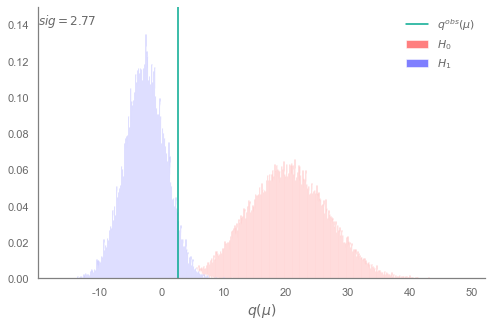

(0.012695, 0.019511718745343392, 0.04989971921379878, 2.7703272333520057)

In [98]:
plt.rc('axes', unicode_minus=False)
stat((d2,d3), (s2,s3), (b2,b3))

## Varie ed eventuali

In [ ]:
read = ROOT.TFile('diLeptonClassification.root')
sig_hist = read.Get('dataset/Method_BDT/BDT2/MVA_BDT2_effS')
bkg_hist = read.Get('dataset/Method_BDT/BDT2/MVA_BDT2_effB')

bins = sig_hist.GetXaxis().GetNbins()
sig = np.array([sig_hist.GetBinContent(i) for i in range(1, bins+1)])
bkg = np.array([bkg_hist.GetBinContent(i) for i in range(1, bins+1)])

x = np.linspace(-0.5,0.4,bins)
signif = sig/np.sqrt(bkg)
n = len(signif)
rms = np.sqrt(1/n * sum(signif))

plt.figure(figsize=(8, 5))
plt.plot(x, signif, color='k')
plt.fill_between(x, signif - rms, signif + rms, alpha=0.2, color = 'fuchsia', label='$\mathrm{RMS}$')
plt.axvline(x[signif.argmax()], color='#00A88F', label='max')
plt.xlabel(r'$q(\mu)$')
plt.ylabel(r'$S_{eff}/\sqrt{B_{eff}}$')
plt.legend(frameon=False)
plt.show()

In [ ]:
sig_hist.GetTitle()

In [ ]:
c1 = ROOT.TCanvas()
c1.cd()
err.Draw('hist')
c1.Draw()

In [ ]:
hist.GetXaxis().GetXmin()

In [ ]:
read.ls()

In [ ]:
read = ROOT.TFile('triLeptonClassification.root')
sig_hist = read.Get('dataset/Method_BDT/BDT3/WeightFileName')

In [ ]:
sig_hist

In [ ]:
read = uproot.open('diLeptonClassification.root')

In [ ]:
read.classnames()